In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms,models
from torch.optim.lr_scheduler import StepLR ,LambdaLR
from torch.utils.data import ConcatDataset


import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.nn import init
import functools
%matplotlib inline

In [2]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic=True

In [3]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3070


In [4]:
transform=transforms.Compose([
    transforms.Resize((210,210)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform1=transforms.Compose([
    transforms.Resize((210,210)),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform2=transforms.Compose([
    transforms.Resize((210,210)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#train
trainset= torchvision.datasets.Flowers102(root='./data', split="test",download=True, transform=transform1)
valset= torchvision.datasets.Flowers102(root='./data', split="test",download=True, transform=transform2)
train=ConcatDataset([trainset, valset])

trainloader = torch.utils.data.DataLoader(train, batch_size=64,shuffle=True, num_workers=6)

#test

testset = torchvision.datasets.Flowers102(root='./data', split="train",
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False,num_workers=6)

In [5]:
class Bottleneck(nn.Module):
    expansion = 3  # 3倍

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel * self.expansion,  # 输出*3
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=102, include_top=True):  # block残差结构 include_top为了之后搭建更加复杂的网络
        super(ResNet, self).__init__()
        self.tan = nn.Tanh()
        self.include_top = include_top
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.tan(x)
        x = self.maxpool(x)

        x = self.tan(self.layer1(x))
        x = self.tan(self.layer2(x))
        x = self.tan(self.layer3(x))
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x
def Net(num_classes=102, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)
net = Net().to(device)
print(net)

ResNet(
  (tan): Tanh()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 192, kernel_size=(1,

In [6]:
#optimizer setting
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(),lr=1e-3,weight_decay=1e-4)


scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                           milestones=[50,100], 
                                           gamma=0.1)
#steplr
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
#                                            milestones=[20], 
#                                            gamma=0.1)


# lambda1 = lambda i: i // 10

# scheduler = LambdaLR(optimizer, lr_lambda=lambda1, last_epoch=-1)

In [7]:
#training


n_epochs =150

# Use GPU if possible
net.to(device)
start_time=time.time()
# Training loop
for epoch in range(n_epochs):
    
    running_loss = 0.0 
    
    # Training procedure
    for i, data in enumerate(trainloader, 0):
        # Get the inputs, labels and put them to GPU if possible 
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i == 0:
          print(f"\nEpoch:{epoch+1}")
        print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.6f},mean:{(running_loss/len(trainloader)):.5f}", end='')
    scheduler.step()    
    
print(f"\nTraining completed {n_epochs} epochs for  {time.time()-start_time:.2f}s!")



Epoch:1
	Batch:193 of 193, loss:3.831091,mean:3.88951
Epoch:2
	Batch:193 of 193, loss:3.733654,mean:2.97276
Epoch:3
	Batch:193 of 193, loss:2.701481,mean:2.54988
Epoch:4
	Batch:193 of 193, loss:3.115835,mean:2.23981
Epoch:5
	Batch:193 of 193, loss:2.673246,mean:1.92715
Epoch:6
	Batch:193 of 193, loss:2.520184,mean:1.69533
Epoch:7
	Batch:193 of 193, loss:2.945621,mean:1.48391
Epoch:8
	Batch:193 of 193, loss:1.842611,mean:1.28856
Epoch:9
	Batch:193 of 193, loss:0.913660,mean:1.10717
Epoch:10
	Batch:193 of 193, loss:0.502734,mean:0.94638
Epoch:11
	Batch:193 of 193, loss:0.939514,mean:0.81468
Epoch:12
	Batch:193 of 193, loss:2.147299,mean:0.71322
Epoch:13
	Batch:193 of 193, loss:0.841455,mean:0.65951
Epoch:14
	Batch:193 of 193, loss:1.006916,mean:0.55429
Epoch:15
	Batch:193 of 193, loss:1.774122,mean:0.48783
Epoch:16
	Batch:193 of 193, loss:0.753644,mean:0.45185
Epoch:17
	Batch:193 of 193, loss:0.386984,mean:0.34700
Epoch:18
	Batch:193 of 193, loss:0.853531,mean:0.34988
Epoch:19
	Batch:19

In [8]:
#test 1
class_correct = [0] *102
class_total = [0]*102
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() ==labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
    
        for i in range(len(c)):
            label = labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
for i in range(len(class_correct)):
    print("Accuracy of %5s : %2d %%" %(i, 100 * class_correct[i]/class_total[i] ))
print("In Accuracy of ALL :%2d %%"% (100 * sum(class_correct)/sum(class_total)))

Accuracy of     0 : 60 %
Accuracy of     1 : 100 %
Accuracy of     2 : 40 %
Accuracy of     3 : 70 %
Accuracy of     4 : 80 %
Accuracy of     5 : 40 %
Accuracy of     6 : 60 %
Accuracy of     7 : 100 %
Accuracy of     8 : 50 %
Accuracy of     9 : 80 %
Accuracy of    10 : 70 %
Accuracy of    11 : 80 %
Accuracy of    12 : 40 %
Accuracy of    13 : 80 %
Accuracy of    14 : 90 %
Accuracy of    15 : 40 %
Accuracy of    16 : 90 %
Accuracy of    17 : 80 %
Accuracy of    18 : 30 %
Accuracy of    19 : 40 %
Accuracy of    20 : 80 %
Accuracy of    21 : 80 %
Accuracy of    22 : 70 %
Accuracy of    23 : 70 %
Accuracy of    24 : 60 %
Accuracy of    25 : 70 %
Accuracy of    26 : 100 %
Accuracy of    27 : 70 %
Accuracy of    28 : 80 %
Accuracy of    29 : 90 %
Accuracy of    30 : 10 %
Accuracy of    31 : 30 %
Accuracy of    32 : 80 %
Accuracy of    33 : 90 %
Accuracy of    34 : 90 %
Accuracy of    35 : 60 %
Accuracy of    36 : 100 %
Accuracy of    37 : 80 %
Accuracy of    38 : 50 %
Accuracy of    39 : 6

Text(204.0, 0.5, 'label(ground_truth)')

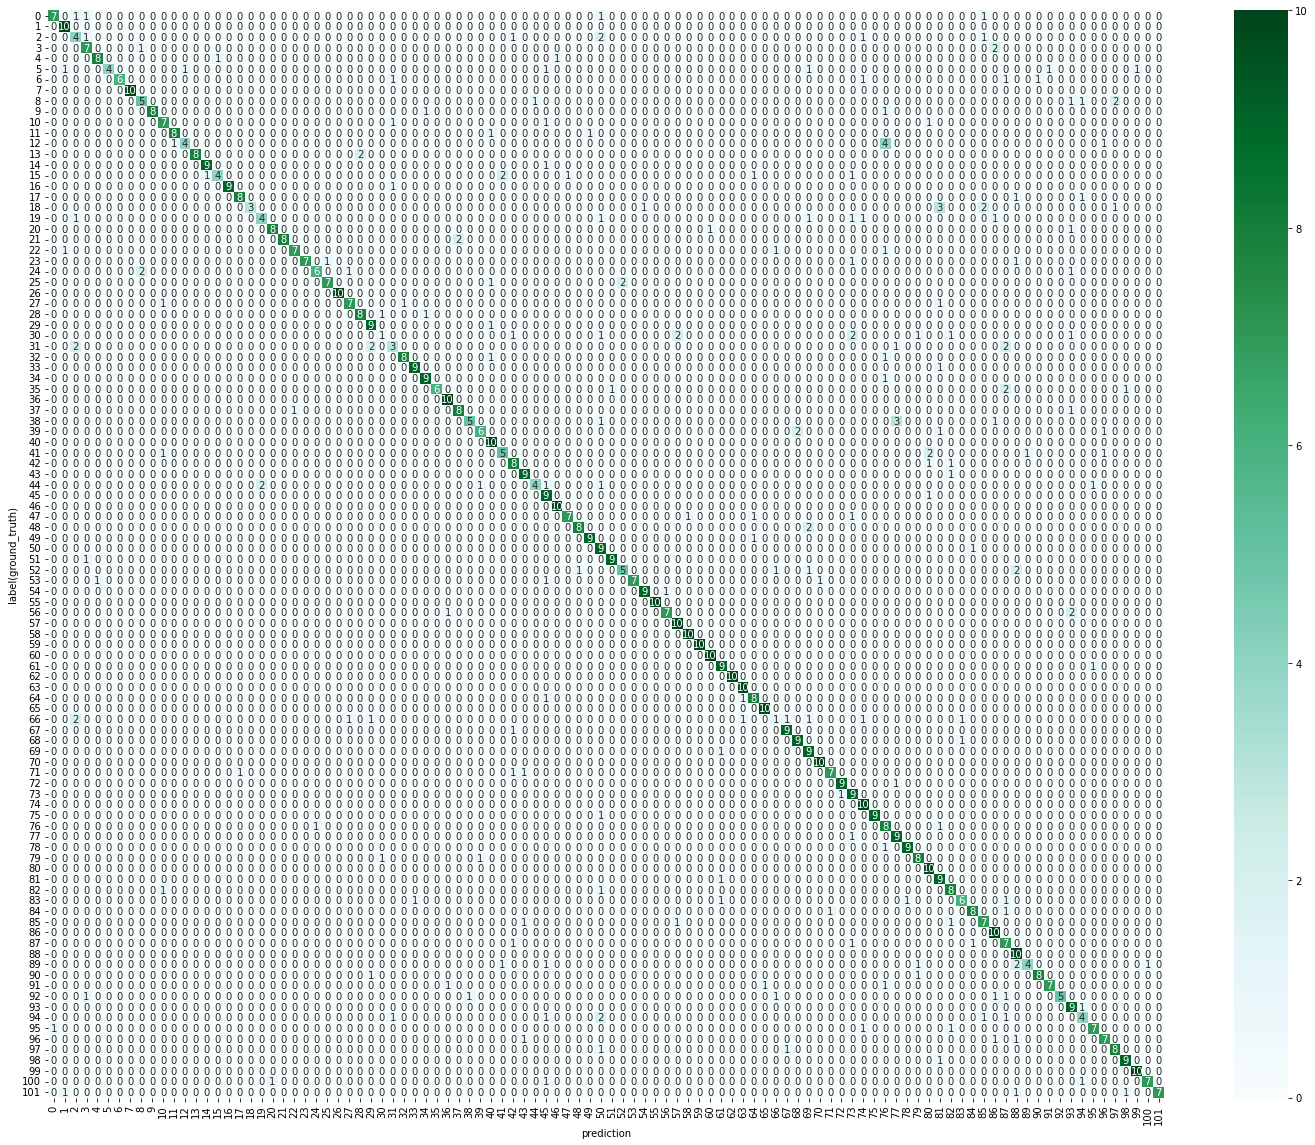

In [9]:
arr=confusion_matrix(truth,preds)
class_names=list(range(102))
df_cm=pd.DataFrame(arr,class_names,class_names)
plt.figure(figsize=(25,20))
sns.heatmap(df_cm, annot=True, fmt="d",cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label(ground_truth)")
